In [1]:
import pandas as pd
from db import Database
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.colors as mpcolors

db = Database()

In [2]:

def get_df(db: Database, mwname, pcap_id, g: bool, pt: str, slot_h=1.0, nn=1, max_slots_h=0):

    if g:
        if pt == 'q':
            where = 'rn_qr=1 and is_r is false'
        elif pt == 'r':
            where = 'rn_qr=1 and is_r is true'
        elif pt == 'ok':
            where = 'rn_qr_rcode=1 and rcode = 0'
        elif pt == 'nx':
            where = 'rn_qr_rcode=1 and rcode = 3'
    else:
        if pt == 'q':
            where = 'is_r is false'
        elif pt == 'r':
            where = 'is_r is true'
        elif pt == 'ok':
            where = 'rcode = 0'
        elif pt == 'nx':
            where = 'rcode = 3'


    slot_seconds = 3600 * slot_h
    upper_where = ''
    if max_slots_h > 0:
        max_slots_time = max_slots_h/slot_h
        upper_where = f' and FLOOR(time_s_translated / {slot_seconds}) < {max_slots_time}'
        pass

    if pcap_id:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_pcap_all3({pcap_id},0)
        where {where} {upper_where}
        """, db.engine)
    else:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_healthy_all2()
        where {where} {upper_where}
        """, db.engine)

    df = df.groupby("hour").aggregate({"pn": "sum", "pp": 'sum'})

    df.index.name = 'slot'

    df.index = df.index - df.index.min()

    df = df.reindex(pd.Index(range(int(df.index.max()))), fill_value=0)

    df.index.name = 'slot'

    df = df.reset_index()

    if any(df.slot.value_counts() > 1):
        raise Exception('Some values are duplicated.')
    
    return df

In [3]:
dfs = {
    'healthy': get_df(db, 'healthy', None, True, 'nx', slot_h=1),
    'caphaw': get_df(db, 'caphaw', 54, True, 'nx', slot_h=1),
    'zbot': get_df(db, 'zbot', 46, True, 'nx', slot_h=1),
    'simda': get_df(db, 'simda', 58, True, 'nx', slot_h=1),
    'unknown': get_df(db, 'unknown', 57, True, 'nx', slot_h=1)
}

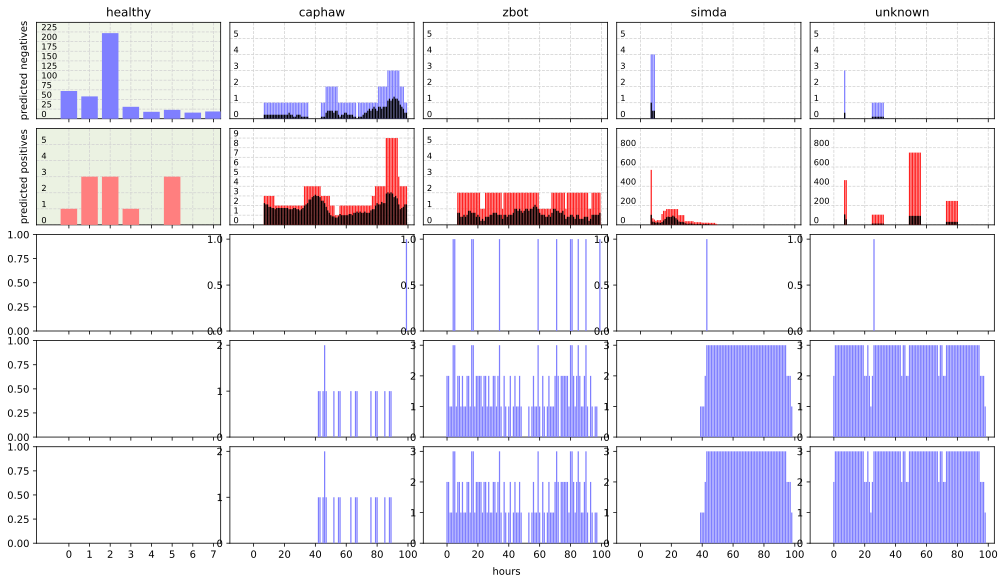

In [35]:

fig, axs = plt.subplots(5, 5, figsize=(14,8), sharey=False, sharex='col')

dfh = dfs['healthy']

dfh.loc[9:, 'pp'] = 0
dfh.loc[9:, 'pn'] = 0


def bo(df_mw, dfh, th):
    values = []
    for i in range(len(df_mw)):
        dfm = df_mw.iloc[i:i+8].reset_index(drop=True)
        df = (dfh + dfm)['pp']

        # if i == 5:
        #     display(pd.concat([dfm, dfh, df], axis=1))
        #     pass
        fps = (dfm['pp'] == 0) & (df > th)
        tps = (dfm['pp'] > 0) & (df > th)
        missed = (tps.sum() == 0) and (dfm['pp'].sum() > 0)

        values.append([fps.sum(), tps.sum(), missed])
        pass
    df = pd.DataFrame(values, columns=['fpr', 'tpr', 'missed'])
    return df


DFH = dfs['healthy'][dfs['healthy'].slot < 8].copy()
i = 0
for mw in dfs:
    df = dfs[mw]
    if mw == 'healthy':
        df = DFH.copy()
        # df['pp'] += 2
        axs[0,i].set_xticks(list(range(8)))
        axs[1,i].set_xticks(list(range(8)))
        axs[0,i].set_facecolor(mpcolors.to_rgba('#cfe1b94a'))
        axs[1,i].set_facecolor(mpcolors.to_rgba('#cfe1b96a'))
        axs[0,i].set_ylabel('predicted negatives')
        axs[1,i].set_ylabel('predicted positives')
    else:
        df = df.iloc[0:100]
        df_max = df.rolling(8).max() # [df.slot < 80]
        df_mean = df.rolling(8).mean() # [df.slot < 80]
        df_bo = bo(df, DFH.copy(), DFH['pp'].max())
        df_bo2 = bo(df, (DFH * 1.2).copy(), DFH['pp'].max())
        df_bo3 = bo(df, (DFH).copy(), 0.8 * DFH['pp'].max())

    negcolor = mpcolors.to_rgba((127/255, 127/255, 255/255, 1))
    poscolor_1 = mpcolors.to_rgba((255/255, 127/255, 127/255, 1))
    poscolor_2 = mpcolors.to_rgba((255/255, 33/255, 33/255, 1))
    black = mpcolors.to_rgba((0, 0, 0, 0.05))

    # axs[i].set_yscale('log')

    if i == 0:
        axs[0,i].bar(df.index, df['pn'], color=negcolor, zorder=20, alpha=1)
        axs[1,i].bar(df.index, df['pp'], color=poscolor_1, zorder=20, alpha=1)
    else:
        axs[0,i].bar(df.index, df_max['pn'], color=negcolor, zorder=10, alpha=1)
        axs[0,i].bar(df.index, df_mean['pn'], color=black, zorder=20, alpha=1)
        axs[1,i].bar(df.index, df_max['pp'], color=poscolor_2, zorder=10, alpha=1)
        axs[1,i].bar(df.index, df_mean['pp'], color=black, zorder=20, alpha=1)
        # axs[2,i].bar(df_bo.index, df_bo['fpr'], color=poscolor_2, zorder=20, alpha=1)
        axs[2,i].bar(df_bo.index, df_bo['missed'], color=negcolor, zorder=10, alpha=1)
        axs[3,i].bar(df_bo2.index, df_bo2['fpr'], color=negcolor, zorder=10, alpha=1)
        axs[4,i].bar(df_bo3.index, df_bo3['fpr'], color=negcolor, zorder=10, alpha=1)
        # axs[1,i].plot(df.index, df_mean['pp'], lw=0.5, color='black', zorder=20)

    for k, col in [(0, 'pn'), (1, 'pp')]:
        p = -20
        if df[col].max() < 5:
            s = 1
            m = 6
            p = -10
        elif df[col].max() < 10:
            s = 1
            m = 10
            p = -10
        elif df[col].max() < 25:
            s = 5
            m = 5
            p = -15
        elif df[col].max() < 50:
            s = 2
            m = int(df[col].max() / s) + 2
            p = -15
        elif df[col].max() < 100:
            s = 20
            m = 5
            p = -15
        elif df[col].max() < 500:
            s = 25
            m = int(df[col].max() / s) + 2
        elif df[col].max() < 1000:
            s = 200
            m = 5
        else:
            s = 25
            pass
        # m = int(df[col].max() / s) + 1
        if m < 5:
            m = 5

        axs[k, i].grid(True, axis='both', linestyle='--', color='lightgray', zorder=-20)
        axs[k, i].set_yticks(list(map(lambda x: int(s * x), range(m))), [])

        axs[k, i].tick_params(axis="y", length=0, direction="in", labelleft=True, labelsize='small', labelcolor='white')
        axs[k, i].set_ylim(0, m*s)

        
        axs[k,i].margins(0.15, s) # 5% padding in all directions

        xlim = axs[k,i].get_xlim()

        for l in range(m):
            axs[k,i].text(xlim[0] + abs(xlim[0]*0.15), l*s, l*s, va='bottom', horizontalalignment='left', size='small')
            pass

        axs[k,i].set_xlim(xlim[0], df.index.max()*1.05)
        pass

    axs[0,i].set_title(mw)
    i += 1
    pass

fig.tight_layout()
fig.text(0.5, -0.01, "hours", ha='center', va='bottom')
fig.subplots_adjust(hspace=0.1, wspace=0.05)